In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
from scipy.linalg import hankel
from ephysvibe.trials import select_trials,align_trials
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants
import os
import platform
# import structures
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.eye_data import EyeData
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData


### Functions

In [2]:
def compute_smooth_temporal_basis(btype,nBases,duration):
    nkbins = duration
    ttb = np.array([np.arange(1,nkbins+1).tolist()]*nBases).T # time indices for basis
    if btype == 'raised cosine':
        # spacing between the centers must be 1/4 of the with of the cosine
        dbcenter = nkbins / (3 + nBases) # spacing between bumps
        width = 4 * dbcenter # width of each bump
        bcenters = 2 * dbcenter + dbcenter*np.arange(0,nBases)
        x=ttb-np.array([bcenters.tolist()]*nkbins)
        period=width
        basis = (abs(x/period)<0.5)*(np.cos(x*2*np.pi/period)*.5+.5)
    elif btype == 'boxcar':
        width = nkbins / nBases
        basis = np.zeros(np.shape(ttb))
        bcenters = width * np.arange(1,nBases+1) - width/2
        for k in np.arange(0,nBases):
            idx = np.logical_and(ttb[:, k] > np.round(width * k) , ttb[:, k] <= np.round(width * (k+1)))
            basis[idx, k] = 1 / sum(idx)

    return basis

In [3]:
def make_non_linear_raised_cos(nBases, binSize, endPoints, nlOffset=1):
    # Make nonlinearly stretched basis consisting of raised cosines.
    # Nonlinear stretching allows faster changes near the event.
    #
    # 	nBases: [1] - # of basis vectors
    #	binSize: time bin size (separation for representing basis
    #   endPoints: [2 x 1] = 2-vector containg [1st_peak  last_peak], the peak
    #          (i.e. center) of the last raised cosine basis vectors (in ms)
    #   nlOffset: [1] offset for nonlinear stretching of x axis (in ms): 
    #          y = log(t+nlOffset) (larger nlOffset -> more nearly linear stretching)
    #
    #  Outputs:  iht = time lattice on which basis is defined
    #            ihbasis = basis itself
    #            ihctrs  = centers of each basis function
    #

    # nonlinearity for stretching x axis (and its inverse)
    def nlin(x):
        return np.log(x + 1e-20)
    def invnl(x):
        return np.exp(x - 1e-20)

    if nlOffset <= 0:
        print('nlOffset must be greater than 0')
    
    yrnge = nlin(endPoints + nlOffset)
    db = (np.diff(yrnge) / (nBases-1))[0] # spacing between raised cosine peaks
    ctrs = np.arange(yrnge[0],yrnge[1]+db,db) # centers for basis vectors
    mxt = invnl(yrnge[1]+2*db) - nlOffset # maximum time bin
    iht = np.arange(0,mxt,binSize)/binSize

    def ff(x,c,dc):
        return (np.cos(np.maximum(-np.pi, np.minimum(np.pi, (x-c)*np.pi/dc/2))) + 1)/2
    x_1= nlin(iht + nlOffset)
    x = np.array([x_1.tolist()]*nBases).T
    c=np.array([ctrs.tolist()]*len(iht))
    ihbasis = ff(x, c, db)
    hctrs = invnl(ctrs)
   
    return ihbasis

In [4]:
def def_stim(len_tr,e_time,e_code,sample_id,sp,test_stimuli):
    stim = {}
    # define stimuli
    stim['hist'] = np.concatenate(([0],sp))
    # fixation
    stim['fix_cue'] = np.zeros(len_tr)
    stim['fix_cue'][int(e_time[2])]=1
    stim['s_on_off']= np.zeros(len_tr)
    stim['s_on_off'][int(e_time[4]):int(e_time[5])]=1
    stim['d_on_off']= np.zeros(len_tr)
    stim['d_on_off'][int(e_time[5]):int(e_time[6])]=1
    # sample features
    stim['s_o1']= np.zeros(len_tr)
    stim['s_o5']= np.zeros(len_tr)
    stim['s_c1']= np.zeros(len_tr)
    stim['s_c5']= np.zeros(len_tr)
    stim['s_n0'] = np.zeros(len_tr)
    stim['d_o1']= np.zeros(len_tr)
    stim['d_o5']= np.zeros(len_tr)
    stim['d_c1']= np.zeros(len_tr)
    stim['d_c5']= np.zeros(len_tr)
    stim['d_n0']= np.zeros(len_tr)
    orientation = sample_id//10
    color = sample_id%10 
    if orientation==1:
        stim['s_o1'][int(e_time[4]):int(e_time[5])]=1
        stim['d_o1'][int(e_time[5]):int(e_time[6])]=1
    elif orientation==5:
        stim['s_o5'][int(e_time[4]):int(e_time[5])]=1
        stim['d_o5'][int(e_time[5]):int(e_time[6])]=1
    elif orientation == 0:
        stim['s_n0'][int(e_time[4]):int(e_time[5])]=1
        stim['d_n0'][int(e_time[5]):int(e_time[6])]=1
    if color==1:
        stim['s_c1'][int(e_time[4]):int(e_time[5])]=1
        stim['d_c1'][int(e_time[5]):int(e_time[6])]=1
    elif color==5:
        stim['s_c5'][int(e_time[4]):int(e_time[5])]=1
        stim['d_c5'][int(e_time[5]):int(e_time[6])]=1
    # test stimuli on off
    stim['match'] = np.zeros(len_tr)
    n_test = np.sum(~np.isnan(test_stimuli))
    max_n_test=test_stimuli.shape[0]
    for i_t in np.arange(max_n_test)+1:
        stim['test_on_off'+str(i_t)] = np.zeros(len_tr) 
        t_on_code = task_constants.EVENTS_B1['test_on_'+str(i_t)]
        t_off_code = task_constants.EVENTS_B1['test_off_'+str(i_t)]
        idx_on = np.where(e_code==t_on_code)[0]
        idx_off = np.where(e_code==t_off_code)[0]
        if i_t<=n_test:
            if i_t ==4 and len(idx_off)==0:
                idx_off = np.where(e_code==task_constants.EVENTS_B1['test_off_5'])[0]
            if i_t==n_test:
                stim['match'][int(e_time[idx_on])]=1
            stim['test_on_off'+str(i_t)][int(e_time[idx_on]):int(e_time[idx_off])]=1
    # test stimuli
    for c_o in np.arange(1,9):
        # orientation
        codes = np.where(test_stimuli//10 == c_o)[0]*2 + 6 
        stim['test_orient'+str(c_o)] = np.zeros(len_tr) 
        if len(codes)!=0:
            for i_c in codes:
                stim['test_orient'+str(c_o)][int(e_time[i_c])]=1 #:int(e_time[i_c+1])
        # color
        codes = np.where(test_stimuli%10 == c_o)[0]*2 + 6
        stim['test_color'+str(c_o)] = np.zeros(len_tr)
        if len(codes)!=0:
            for i_c in codes:
                stim['test_color'+str(c_o)][int(e_time[i_c])]=1#:int(e_time[i_c+1])
    # bar_release
    stim['bar_release'] = np.zeros(len_tr)
    bar_release = np.where(e_code==4)[0]
    if len(bar_release)==1:
        stim['bar_release'][int(e_time[bar_release])]=1

    return stim

### Analysis

In [5]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [6]:
# Load data
neu_path = basepath+"/session_struct/lip/neurons/2023-11-30_11-16-24_Riesling_lip_e1_r1_good1_neu.h5"#2023-11-30_11-16-24_Riesling_lip_e1_r1_good1   2023-12-06_11-17-19_Riesling_lip_e1_r1_good4
eye_path = basepath+"work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/eye/2023-11-28_11-15-50_Riesling_e1_r1_eye.h5"
# sp_path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/v4/spikes/2023-11-28_11-15-50_Riesling_v4_e1_r1_sp.h5"
# bhv_path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/bhv/2023-11-28_11-15-50_Riesling_e1_r1_bhv.h5"
neu_data = NeuronData.from_python_hdf5(neu_path)
#eye_data = EyeData.from_python_hdf5(eye_path)
# sp_data = SpikeData.from_python_hdf5(sp_path)
# bhv_data = BhvData.from_python_hdf5(bhv_path)

### Preproces data
* select trials 
* define stimulus
* define basis
* convole stimulus with its corresponding base -> desing matrix
* stack spikes and desing matrices

In [7]:
# parameters
time_before=0
select_block=1
# start=-200
# end=1200
# idx_start = time_before + start 
# idx_end = time_before+end

In [8]:
# Select trials aligned to start_trial
code=1
sp_sample_on,mask = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block= select_block,
    select_pos= code,
    event ="sample_on",
    time_before = time_before,
    error_type= 0,
)

In [9]:
import glm_functions

In [10]:
# Number of basis for each stimulus
fix_cue_dim=4
fixation_dim=5
sample_dim=15
delay_dim=15
test_dim=10
match_dim=4
bar_dim=4
hist_cos_dim = 10
hist_box_dim = 10
hist_dim = hist_cos_dim+hist_box_dim
# Compute basis
cos_basis=glm_functions.make_non_linear_raised_cos(nBases=hist_cos_dim, binSize=1, endPoints=np.array([10,150]), nlOffset=1)
single_bin_boxcars = np.zeros((cos_basis.shape[0],hist_box_dim))
single_bin_boxcars[range(hist_box_dim),range(hist_box_dim)]=1
hist_basis = np.concatenate((single_bin_boxcars,cos_basis),axis=1)
fix_cue_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=fix_cue_dim,duration=500)
fixation_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=fixation_dim,duration=1200)
sample_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=sample_dim,duration=400)
delay_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=delay_dim,duration=400)
test_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=test_dim,duration=400)
match_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=match_dim,duration=400)
bar_release_basis = glm_functions.compute_smooth_temporal_basis(btype='raised cosine',nBases=bar_dim,duration=80)
basis={'fix_cue':fix_cue_basis,'fixation':fixation_basis,'hist':hist_basis,
       's_on_off':[np.nan],
       's_o1':sample_basis,'s_o5':sample_basis,
       's_c1':sample_basis,'s_c5':sample_basis,'s_n0':sample_basis,
       'd_o1':delay_basis,'d_o5':delay_basis,'d_c1':delay_basis,'d_c5':delay_basis,'d_n0':delay_basis,'d_on_off':[np.nan]}
for i in range(1,9):
    basis['test_color'+str(i)] = test_basis
    basis['test_orient'+str(i)] = test_basis
for i in range(1,5):
    basis['test_on_off'+str(i)] = [np.nan]
basis['match'] = match_basis
basis['bar_release'] = bar_release_basis

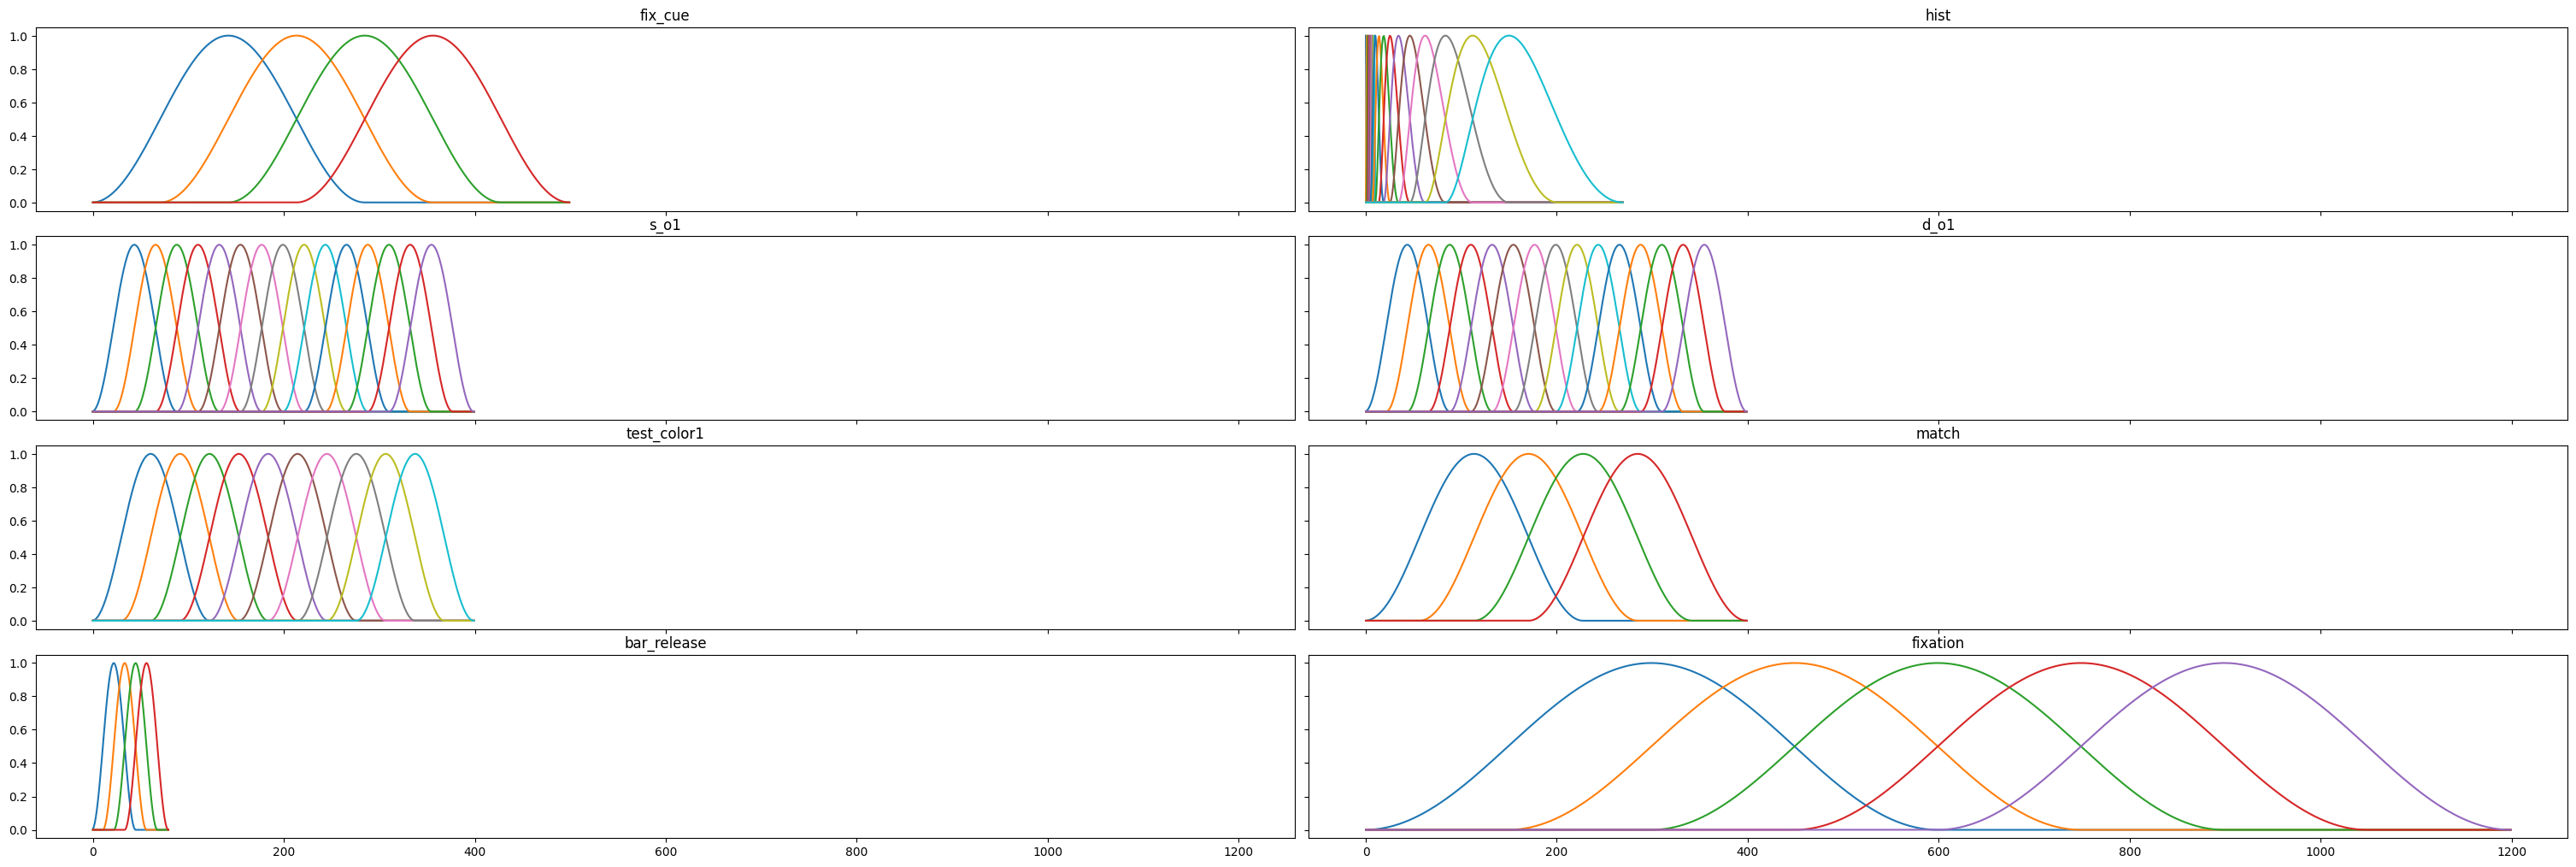

In [11]:
# print filters
basis_keys = ['fix_cue', 'hist', 's_o1', 'd_o1', 'test_color1', 'match', 'bar_release','fixation']
cols = 2
rows = len(basis_keys)//cols
rows =rows +1 if len(basis_keys)%cols>0 else rows
f,ax=plt.subplots(rows,cols,figsize=(30,10),sharey=True,sharex=True)
for iax,var in zip(np.concatenate(ax),basis_keys):
    iax.plot(basis[var])
    iax.set_title(var)
f.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)

In [12]:
from joblib import Parallel, delayed
from tqdm import tqdm

In [13]:
basis['fixation'].shape

(1200, 5)

In [14]:
# iterate over trials
def get_dm(i_tr):

    e_time = neu_data.code_samples[mask][i_tr]-neu_data.code_samples[mask][i_tr][4]+time_before
    e_code = neu_data.code_numbers[mask][i_tr]
    test_stimuli = neu_data.test_stimuli[mask][i_tr]
    # n_test=np.sum(~np.isnan(test_stimuli))
    reward = task_constants.EVENTS_B1[last_event]
    idx_last = np.where(e_code==reward)[0]

    len_tr=int(e_time[idx_last][0]+10)
    sample_id = neu_data.sample_id[mask][i_tr]
    stim = glm_functions.def_stim(events,len_tr,e_time,e_code,sample_id,sp_sample_on[i_tr,:len_tr],test_stimuli)
    all_dm = {}
    indices = {}
    design_mat=np.zeros((len_tr,1))
    shape = 0
    for key in events:
        base=basis[key]
        if np.any(np.isnan(base)):
            all_dm[key]=stim[key][:,np.newaxis]
        else:
            sb_conv = signal.convolve2d(stim[key][:,np.newaxis],base)
            all_dm[key]=sb_conv[:len_tr]
        indices[key]=[shape,shape+all_dm[key].shape[1]]
        shape = shape+all_dm[key].shape[1]
        design_mat = np.concatenate((design_mat,all_dm[key]), axis=1)

    return {"design_mat":design_mat[:,1:],"all_dm":all_dm,"stim":stim,"len_tr":len_tr,"s_on":e_time[4],"fix_on":e_time[2],"delay_on":e_time[5],"test1_on":e_time[6],"indices":indices,"sp":sp_sample_on[i_tr,:len_tr]}


In [15]:
events = [
    # "fix_cue",
    # "fixation",
    "hist",
    "s_o1",
    "s_o5",
    "s_c1",
    "s_c5",
    "s_n0",
    "s_on_off",
    "d_o1",
    "d_o5",
    "d_c1",
    "d_c5",
    "d_n0",
    "d_on_off",
    # "test_orient1",
    # "test_orient2",
    # "test_orient3",
    # "test_orient4",
    # "test_orient5",
    # "test_orient6",
    # "test_orient7",
    # "test_orient8",
    # "test_color1",
    # "test_color2",
    # "test_color3",
    # "test_color4",
    # "test_color5",
    # "test_color6",
    # "test_color7",
    # "test_color8",
    # "match",
    # "bar_release",
]
last_event = "test_on_1"#"reward"

In [16]:
sample_id=neu_data.sample_id[mask]
sn0= np.where(sample_id== 0)[0][:10]
s15= np.where(sample_id== 15)[0][:10]
s11= np.where(sample_id== 11)[0][:10]
s55= np.where(sample_id== 55)[0][:10]
s51= np.where(sample_id== 51)[0][:10]
idxs_train =np.concatenate((sn0,s15,s11,s55,s51))
rng = np.random.default_rng(seed=2024)
rng.shuffle(idxs_train)

sample_id=neu_data.sample_id[mask]
sn0= np.where(sample_id== 0)[0][15:20]
s15= np.where(sample_id== 15)[0][15:20]
s11= np.where(sample_id== 11)[0][15:20]
s55= np.where(sample_id== 55)[0][15:20]
s51= np.where(sample_id== 51)[0][15:20]
idxs_test =np.concatenate((sn0,s15,s11,s55,s51))
rng = np.random.default_rng(seed=2024)
rng.shuffle(idxs_test)
idxs_test
idxs = np.concatenate((idxs_train,idxs_test))

In [17]:
n_tr,_ = sp_sample_on.shape
data    =   Parallel(n_jobs = -1)(delayed(get_dm)(i_tr) for i_tr in tqdm(idxs))

100%|██████████| 75/75 [00:36<00:00,  2.07it/s]


In [18]:
design_mat = []
all_dm =[]
all_len_tr = []
all_s_on = []
all_fix_on=[]
all_stim=[]
all_sp = []
all_d_on=[]
all_test1_on=[]
for asc in data:
    design_mat.append(asc["design_mat"])
    all_dm.append(asc["all_dm"])
    all_len_tr.append(asc["len_tr"])
    all_s_on.append(asc["s_on"])
    all_fix_on.append(asc["fix_on"])
    all_d_on.append(asc["delay_on"])
    all_stim.append(asc["stim"])
    all_sp.append(asc["sp"])
    all_test1_on.append(asc["test1_on"])
indices= data[0]["indices"]

In [19]:
all_stim[0].keys()

dict_keys(['hist', 's_on_off', 's_o1', 's_o5', 's_c1', 's_c5', 's_n0', 'not_engage', 'd_on_off', 'd_o1', 'd_o5', 'd_c1', 'd_c5', 'd_n0'])

In [20]:
i_trs=0
neu_data.sample_id[mask][idxs_train][i_trs]

55.0

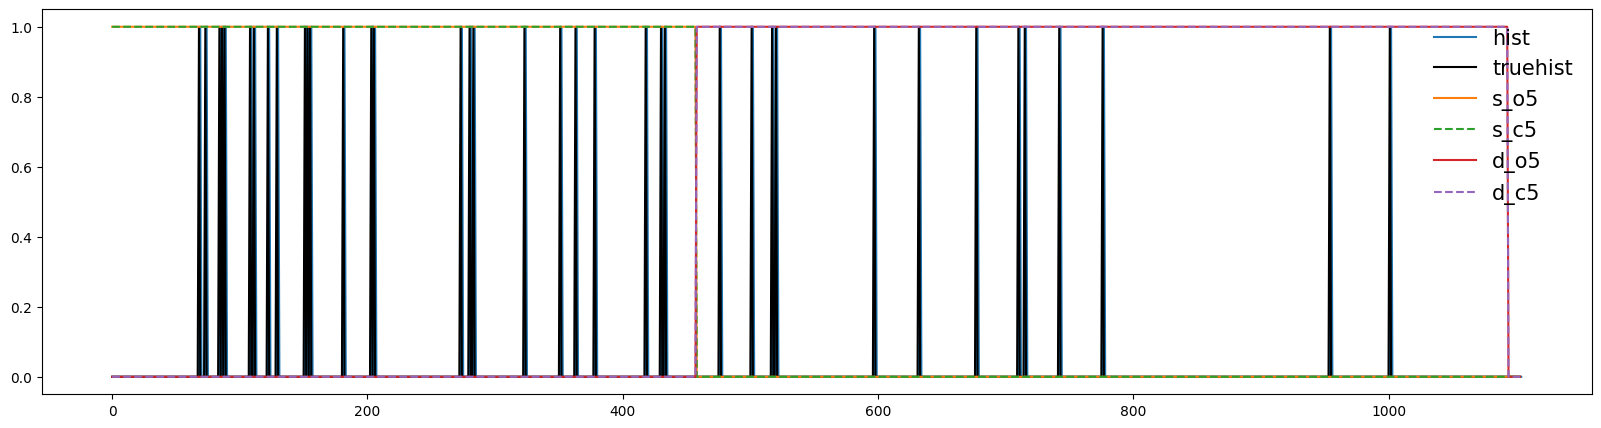

In [21]:
f,ax=plt.subplots(figsize=(20,5))
#ax.plot(all_stim[0]['fixation'],label='fixation')
ax.plot(all_stim[0]['hist'],label='hist')
ax.plot(all_sp[0],'k',label='truehist')
#ax.plot(all_stim[0]['fix_cue'],label='fix_cue')
ax.plot(all_stim[0]['s_o5'],label='s_o5')
ax.plot(all_stim[0]['s_c5'],label='s_c5',linestyle='--')
ax.plot(all_stim[0]['d_o5'],label='d_o5')
ax.plot(all_stim[0]['d_c5'],label='d_c5',linestyle='--')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')

In [22]:
n_train_tr = len(idxs_train)#int(100*0.490)
n_train_tr

50

In [23]:
# train
sp_train=np.concatenate(all_sp[:n_train_tr])
print("Length of all trials concatenated: %s"%sp_train.shape)
dm_train=np.concatenate(design_mat[:n_train_tr])
print("Shape of dm: (%s, %s)"%dm_train.shape)
len_tr_train=np.array(all_len_tr)[:n_train_tr]
print("Number of trials %s"%len_tr_train.shape)
s_on_train=np.array(all_s_on)[:n_train_tr]
fix_on_train=np.array(all_fix_on)[:n_train_tr]
d_on_train=np.array(all_d_on)[:n_train_tr]
test1_on_train=np.array(all_test1_on)[:n_train_tr]
# test 
sp_test=np.concatenate(all_sp[n_train_tr:])
print("Length of all trials concatenated: %s"%sp_test.shape)
dm_test=np.concatenate(design_mat[n_train_tr:])
print("Shape of dm: (%s, %s)"%dm_test.shape)
len_tr_test=np.array(all_len_tr)[n_train_tr:]
print("Number of trials %s"%len_tr_test.shape)
s_on_test=np.array(all_s_on)[n_train_tr:]
fix_on_test=np.array(all_fix_on)[n_train_tr:]
d_on_test=np.array(all_d_on)[n_train_tr:]
test1_on_test=np.array(all_test1_on)[n_train_tr:]

Length of all trials concatenated: 56409
Shape of dm: (56409, 172)
Number of trials 50
Length of all trials concatenated: 28185
Shape of dm: (28185, 172)
Number of trials 25


In [24]:
x=dm_train
mu = np.mean(x,axis=0)
sigma = np.std(x,axis=0)
sigma0 = sigma
sigma0[sigma0==0] = 1
dm_train = (x-mu) / sigma0

x=dm_test
mu = np.mean(x,axis=0)
sigma = np.std(x,axis=0)
sigma0 = sigma
sigma0[sigma0==0] = 1
dm_test = (x-mu) / sigma0

### with statsmodels

In [ ]:
from pyglmnet import GLM

In [ ]:
from scipy.optimize import minimize

In [ ]:
# #Fit poisson GLM using ML
# T,nreg=dm_train.shape
# design_mat_offset = np.hstack((np.ones((T,1)), dm_train))#dm_train))     # add a column of ones
# #design_mat_offset = np.array(design_mat_offset,dtype=np.float128)
# # Get the MLE weights for the model (Linear Gaussian GLM)
# lg_weights = np.linalg.inv(design_mat_offset.T @ design_mat_offset) @ design_mat_offset.T @ sp_train
# rng = np.random.default_rng(seed=2024)
# lg_weights = rng.normal(0,1,(nreg+1))
# #lg_weights=np.zeros(lg_weights.shape)
# dt_fine=1
# # -- Make loss functions and minimize -----
# loss_func = lambda prs : glm_functions.neg_log_lik_lnp(prs, design_mat_offset, sp_train, dt_fine, vals_to_return=0)
# grad_func = lambda prs : glm_functions.neg_log_lik_lnp(prs, design_mat_offset, sp_train, dt_fine, vals_to_return=1)
# hess_func = lambda prs : glm_functions.neg_log_lik_lnp(prs, design_mat_offset, sp_train, dt_fine, vals_to_return=2)
# optimizer = minimize(fun=loss_func, x0=lg_weights, jac=grad_func, hess=hess_func,method='SLSQP', options={'disp':True, 'gtol':1e-6, 'maxiter': 10})
# filt_ML = optimizer.x

In [25]:
### Fit GLM
T,nreg=dm_train.shape
rng = np.random.default_rng(seed=2)
lg_weights = rng.normal(0,1,(nreg+1))
design_mat_offset = np.hstack((np.ones((T,1)), dm_train))     # add a column of ones
# Fit GLM 
print('Fitting Poisson GLM...')
glm_model = sm.GLM(endog=sp_train, exog=design_mat_offset,
                         family=sm.families.Poisson()) # assumes 'log' link.
glm_result = glm_model.fit(start_params=lg_weights,max_iter=10, tol=1e-6, tol_criterion='params')
print("Done")

Fitting Poisson GLM...
Done


In [26]:
print("Converged: %s"%glm_result.converged)
print(glm_result.summary())

Converged: False
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                56409
Model:                            GLM   Df Residuals:                    56266
Model Family:                 Poisson   Df Model:                          142
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5740.0
Date:                Wed, 24 Jan 2024   Deviance:                       8574.1
Time:                        11:45:32   Pearson chi2:                 5.13e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.03584
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4530      0.057   

In [27]:
indices.keys()

dict_keys(['hist', 's_o1', 's_o5', 's_c1', 's_c5', 's_n0', 's_on_off', 'd_o1', 'd_o5', 'd_c1', 'd_c5', 'd_n0', 'd_on_off'])

In [28]:
dm_train.shape

(56409, 172)

In [30]:
# 0:const, 1:dm_fix, 2:dm_so1, 3:dm_so5,4:dm_sc1,5:dm_sc5,6:dm_sn0,7:dm_hist,8:sample_on_off,9:dm_do1,10:dm_do5,11:dm_dc1,12:dm_dc5,13:dm_dn0,14:delay_on_off
wparams=glm_result.params
variables = list(indices.keys())
glm_vars = {}
glm_const = wparams[0:1]#
glm_vars["glm_const"]=glm_const
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    glm_vars[var] = wparams[st+1:ed+1]# glm_result.params

In [31]:
rate_pred_train = np.exp(glm_const + dm_train@ wparams[1:])#glm_result.params

KeyError: 'test_orient1'

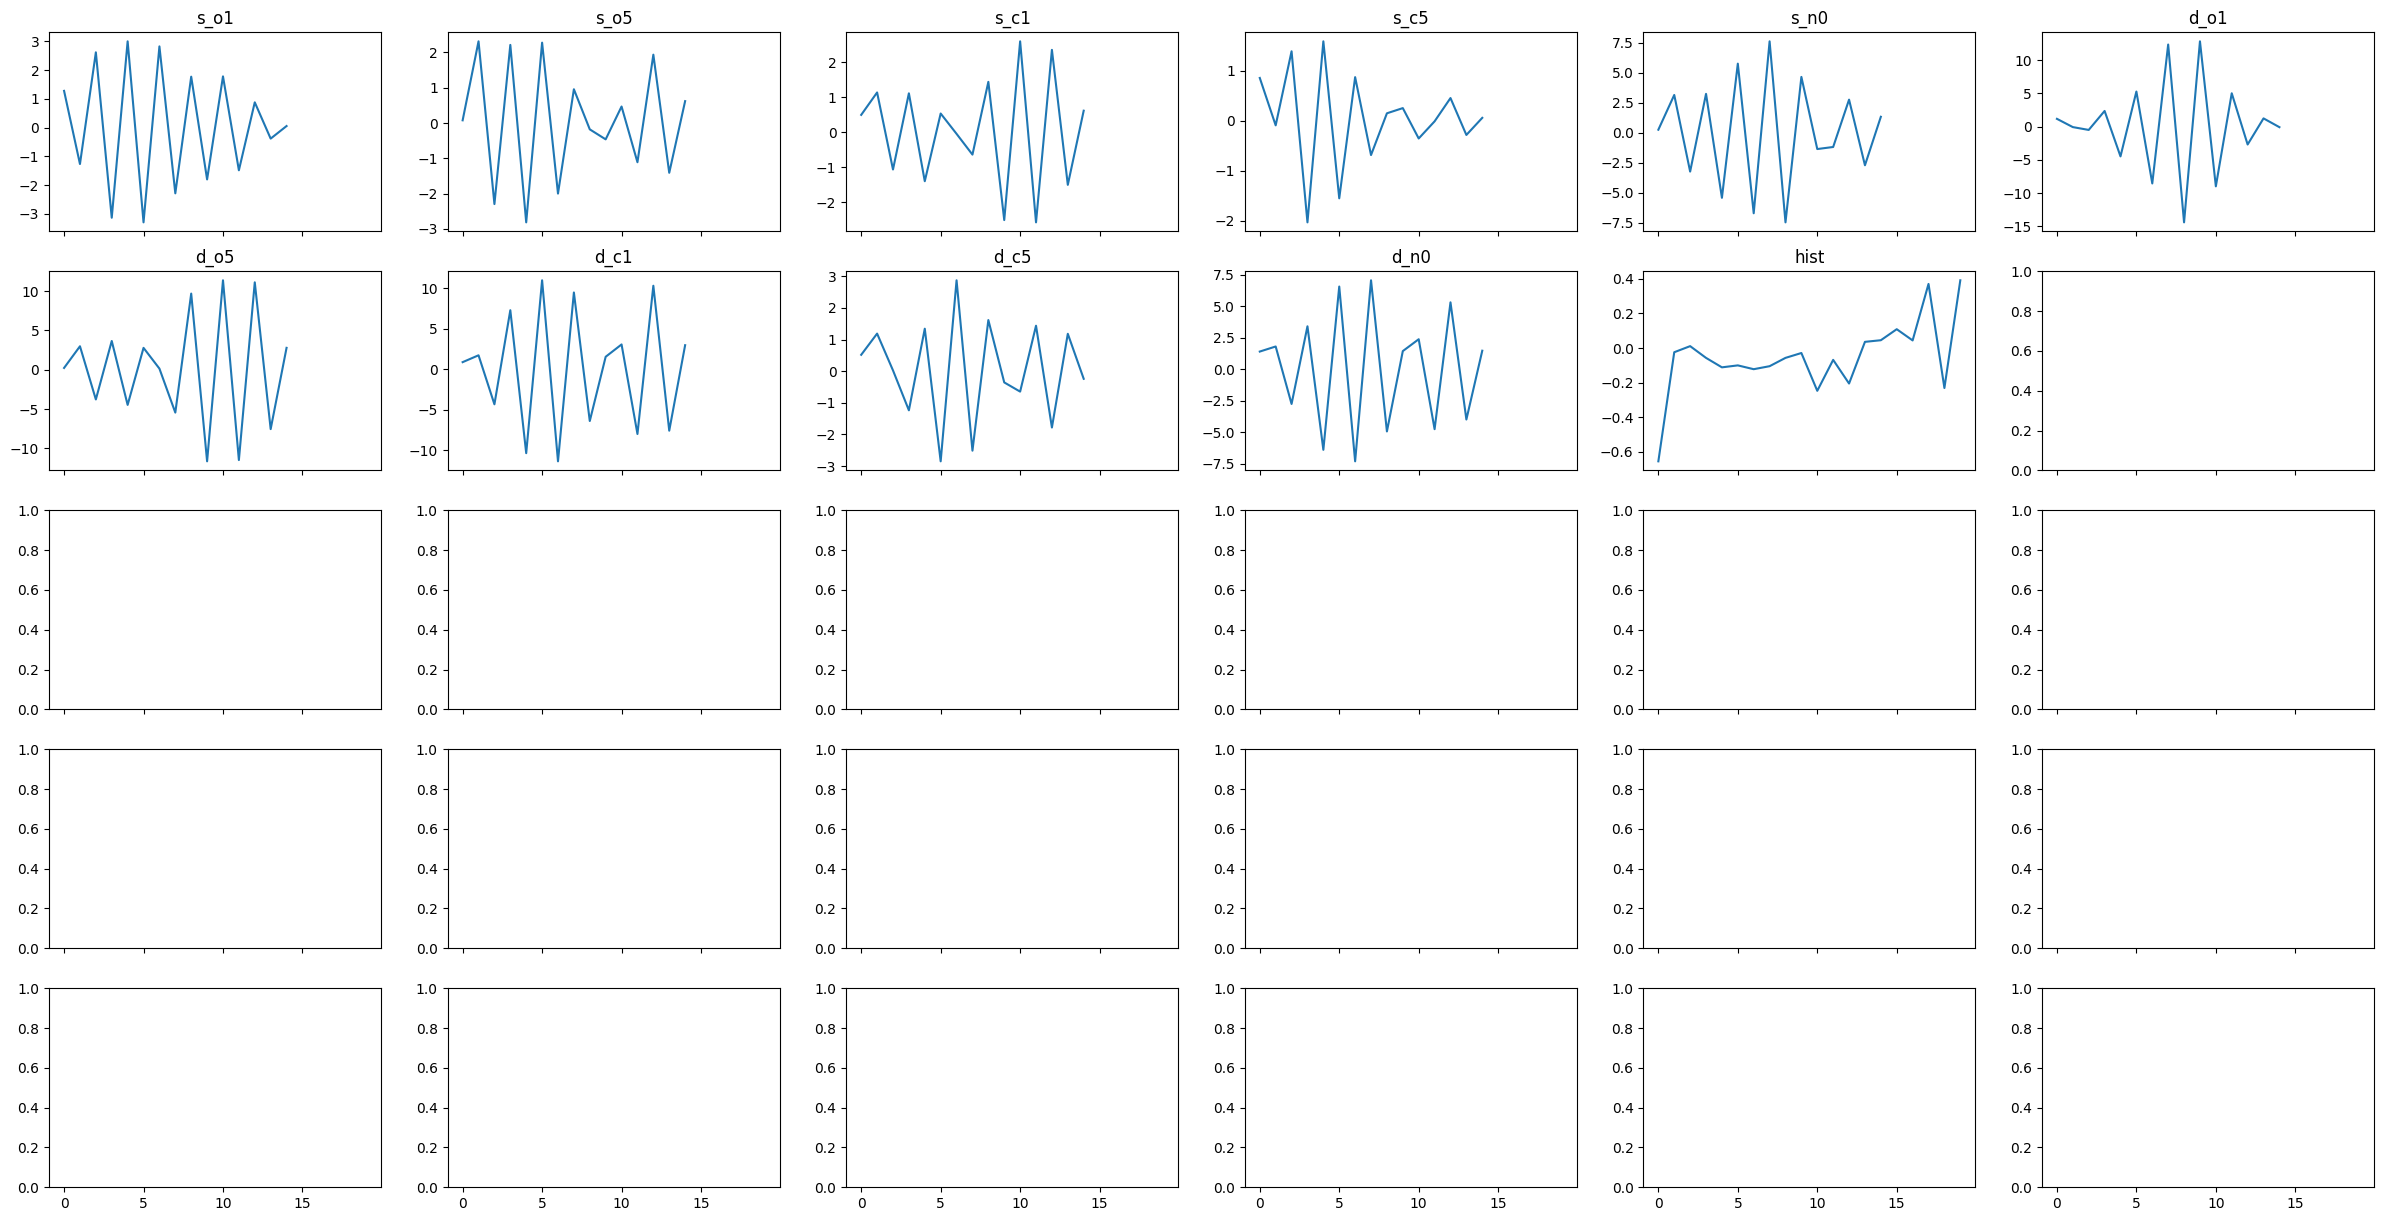

In [32]:
# print filters
variables = [ 's_o1', 's_o5', 's_c1', 's_c5', 's_n0', 'd_o1', 'd_o5', 'd_c1', 'd_c5', 'd_n0','hist','test_orient1', 'test_color1', 
             'test_orient2', 'test_color2', 'test_orient3', 'test_color3', 'test_orient4', 'test_color4', 'test_orient5', 'test_color5', 
             'test_orient6', 'test_color6', 'test_orient7', 'test_color7', 'test_orient8', 'test_color8']
cols = 6
rows = len(variables)//cols
rows =rows +1 if len(variables)%cols>0 else rows
f,ax=plt.subplots(rows,cols,figsize=(30,15),sharex=True)
for iax,var in zip(np.concatenate(ax),variables):
    iax.plot(glm_vars[var])
    iax.set_title(var)
f,ax=plt.subplots(figsize=(5,5))
ax.plot(glm_vars['hist'])

In [ ]:
dm_train.shape

(56409, 172)

In [33]:
cumsum = np.cumsum(len_tr_train)
cumsum=np.concatenate(([0],cumsum))
start = cumsum[:-1]
end = cumsum[1:]

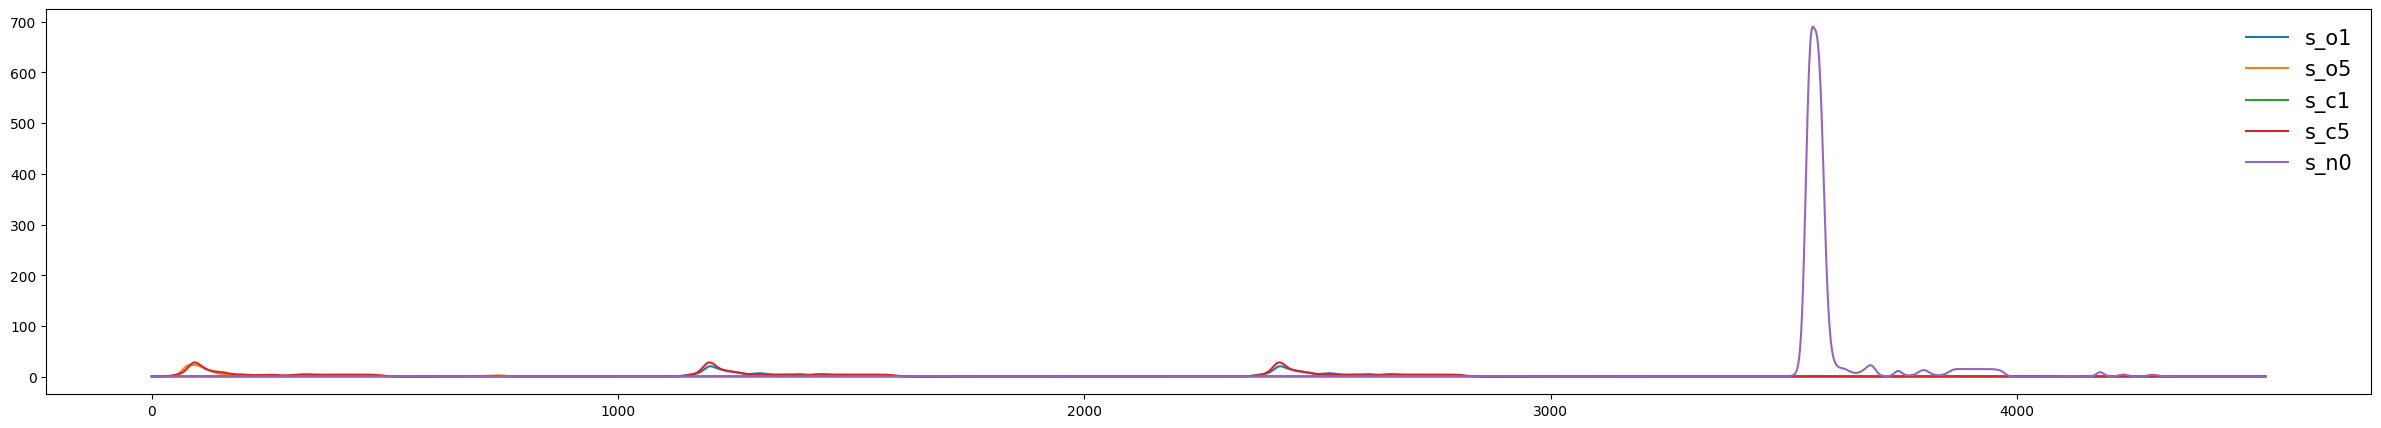

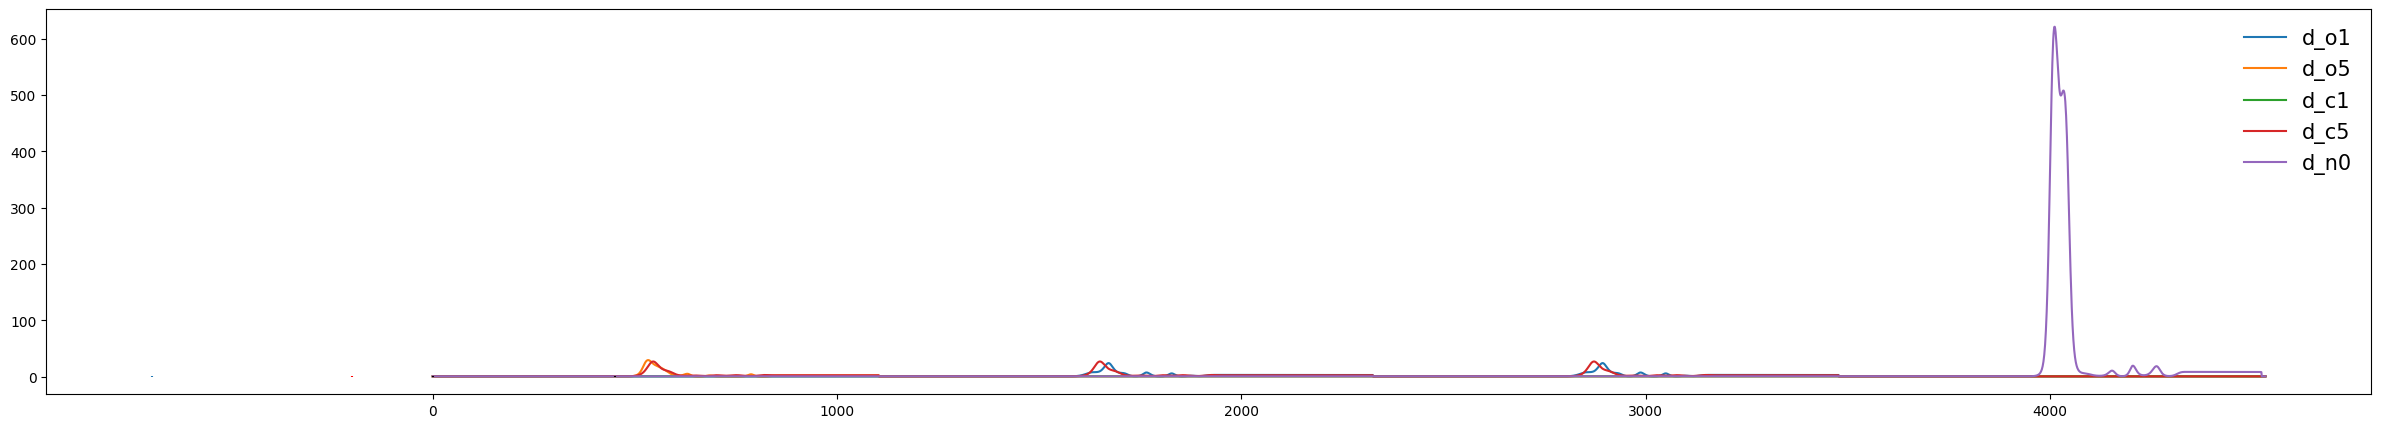

In [44]:
variables = ['s_o1', 's_o5', 's_c1', 's_c5', 's_n0']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component= np.exp( dm_train[:,st:ed] @ glm_vars[var])
    
    plt.plot(component[int(start[0]):end[3]+10],label = var)
# plt.vlines(s_on_train[0]-200,0,2,'r')
# plt.vlines(s_on_train[0],0,2,'k')
# plt.vlines(fix_on_train[0],0,2)
# plt.vlines(s_on_train[0]+450,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
variables = [ 'd_o1', 'd_o5', 'd_c1', 'd_c5', 'd_n0']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
    
    plt.plot(component[int(start[0]):end[3]+10],label = var)
plt.vlines(s_on_train[0]-200,0,2,'r')
plt.vlines(s_on_train[0],0,2,'k')
plt.vlines(fix_on_train[0],0,2)
plt.vlines(s_on_train[0]+450,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')



KeyError: 'test_color1'

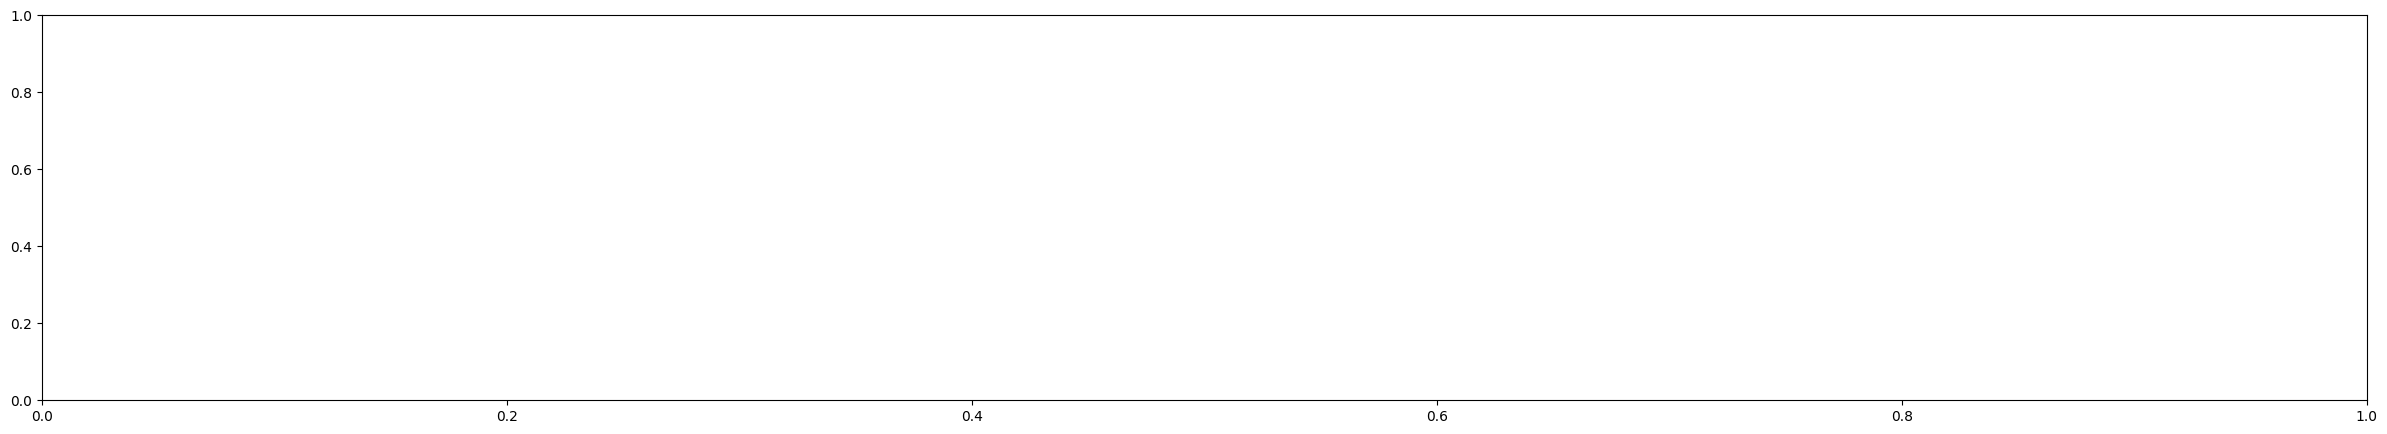

In [35]:
variables = [ 'test_color1', 
              'test_color2',  'test_color3',  'test_color4',  'test_color5', 
              'test_color6',  'test_color7',  'test_color8']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
    
    plt.plot(component[int(start[0]):end[-1]+10],label = var)
plt.vlines(s_on_train[0]-200,0,2,'r')
plt.vlines(s_on_train[0],0,2,'k')
plt.vlines(fix_on_train[0],0,2)
plt.vlines(s_on_train[0]+450,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
variables = ['test_orient1', 
             'test_orient2', 'test_orient3', 'test_orient4']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
   
    plt.plot(component[int(start[0]):end[0]+10],label = var)
plt.vlines(s_on_train[0]-200,0,2,'r')
plt.vlines(s_on_train[0],0,2,'k')
plt.vlines(fix_on_train[0],0,2)
plt.vlines(s_on_train[0]+450,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')

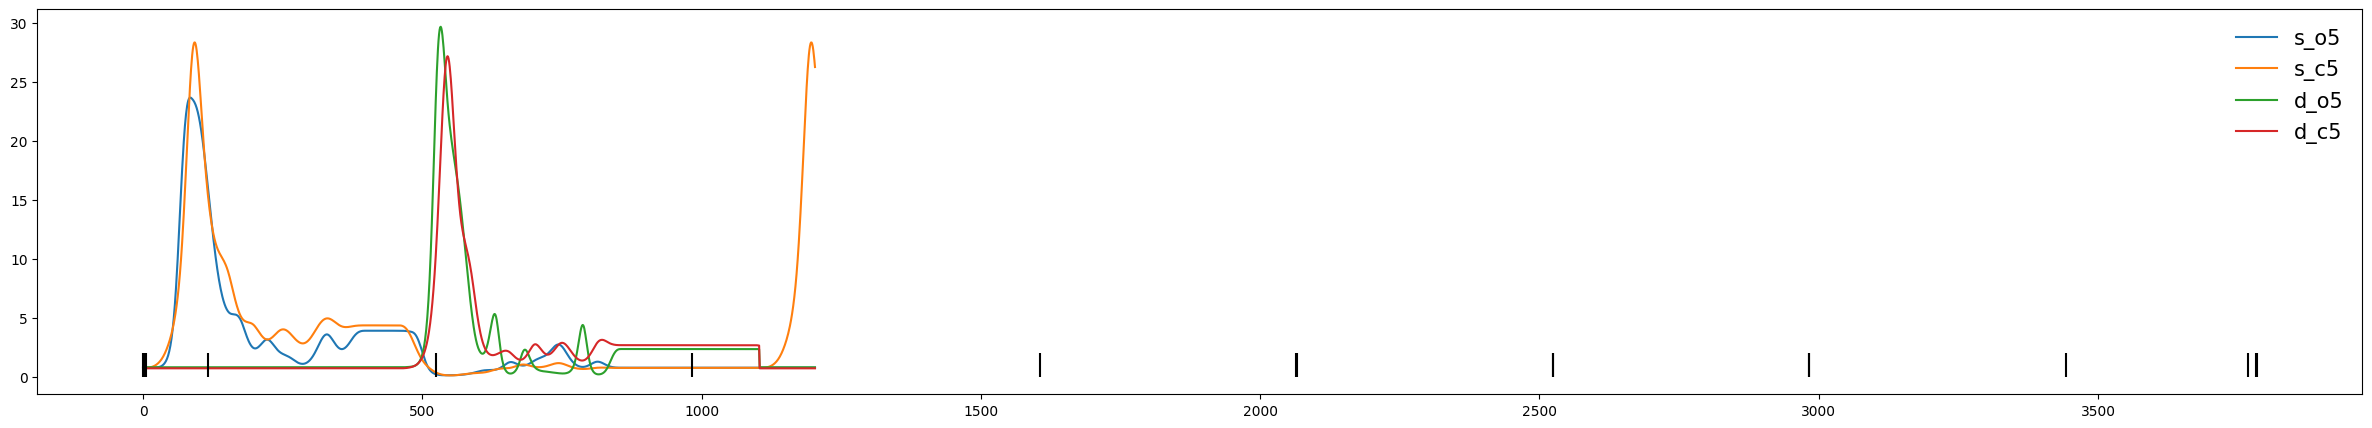

In [45]:
variables = [ 's_o5', 's_c5','d_o5', 'd_c5']#,'test_orient1', 'test_orient8', 'test_orient5', 'test_color5', 'test_color1','match','bar_release']
plt.subplots(figsize=(30,5))
for var in variables:
    st = indices[var][0]
    ed = indices[var][1]
    component = np.exp( dm_train[:,st:ed] @ glm_vars[var])
   
    plt.plot(component[int(start[0]):end[0]+100],label = var)

plt.vlines(neu_data.code_samples[mask][3]-1000,0,2,'k')
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')

In [37]:
def get_component(var,dm,glm_vars,indices,start,end):
    st = indices[var][0]
    ed = indices[var][1]
    component= np.exp( dm[:,st:ed] @ glm_vars[var])
    return component[start:end]

In [38]:
var='s_c5'
idx=np.where(neu_data.sample_id[mask][idxs_train]==55)[0]
st= int(start[idx[0]]+s_on_train[idx[0]])
ed=end[idx[0]]
get_component(var,dm_train,glm_vars,indices,start=st,end=ed)

array([0.75150398, 0.75170527, 0.75215742, ..., 0.7514536 , 0.7514536 ,
       0.7514536 ])

In [39]:
st

0

In [40]:
all_components={}
# fixation
# var='fix_cue'
# # st = indices[var][0]
# # ed = indices[var][1]
# # component= np.exp( dm_train[:,st:ed] @ glm_vars[var])
# # all_components[var] = component[start[0]:end[0]]
# st = start[0]
# ed = end[0]
# all_components[var] = get_component(var,dm_train,glm_vars,indices,start=st,end=ed)
# # sample
t_befs= 0#400
vars = ['s_o1','s_o5','s_c1','s_c5','s_n0']
sampl_ids = [11,55,11,55,0]
for var, s_id in zip(vars,sampl_ids):
    idx=np.where(neu_data.sample_id[mask][idxs_train]==s_id)[0]
    st= int(start[idx[0]]+s_on_train[idx[0]]-t_befs)
    ed=end[idx[0]]
    all_components[var] = get_component(var,dm_train,glm_vars,indices,start=st,end=ed)
# delay
vars = ['d_o1','d_o5','d_c1','d_c5','d_n0']
t_befd = 400
sampl_ids = [11,55,11,55,0]
for var, s_id in zip(vars,sampl_ids):
    idx=np.where(neu_data.sample_id[mask][idxs_train]==s_id)[0]
    st= int(start[idx[0]]+d_on_train[idx[0]]-t_befd)
    ed=end[idx[0]]
    all_components[var] = get_component(var,dm_train,glm_vars,indices,start=st,end=ed)


KeyError: 'fix_cue'

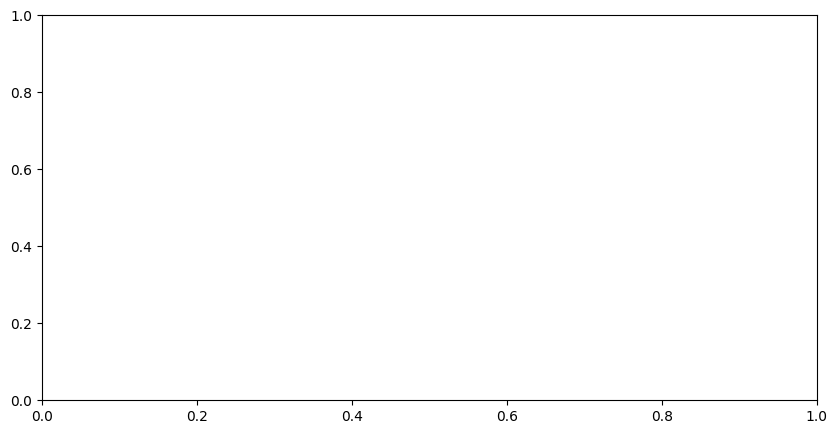

In [41]:
var='fix_cue'
plt.subplots(figsize=(10,5))
t=np.arange(len(all_components[var]))-s_on_train[0]
plt.plot(t,all_components[var],label=var)
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
plt.suptitle("Component")

In [42]:
all_components['s_c5']

array([0.75150398, 0.75170527, 0.75215742, ..., 0.7514536 , 0.7514536 ,
       0.7514536 ])

Text(0.5, 0.98, 'Component')

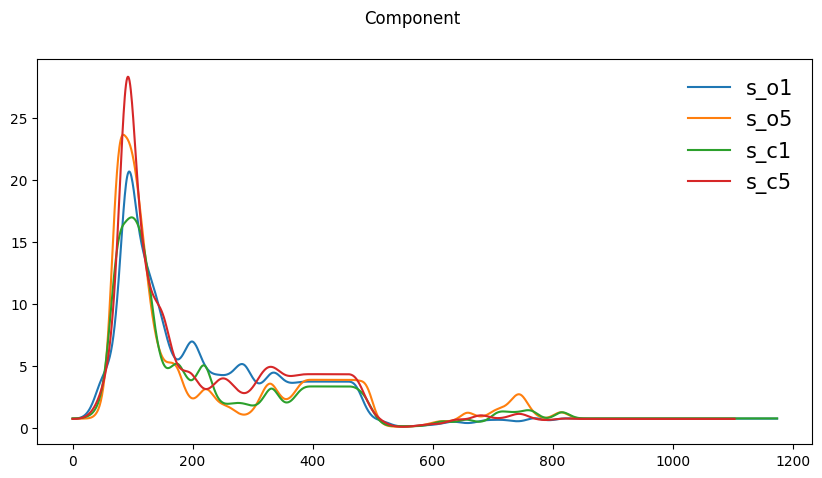

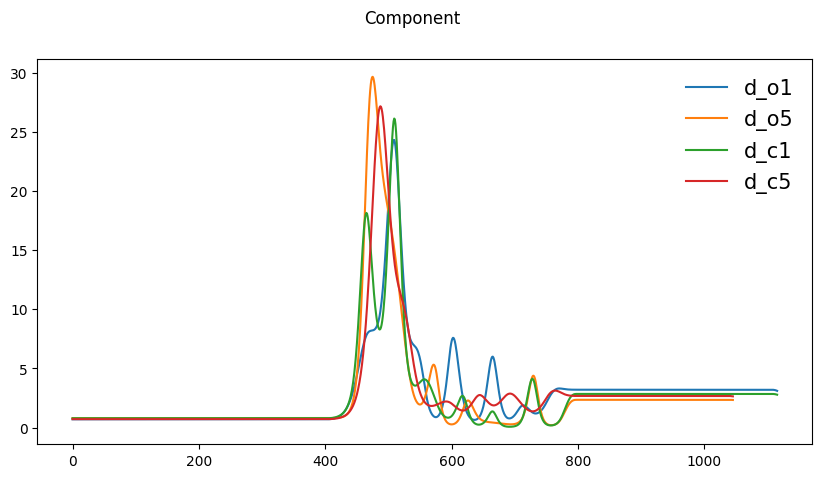

In [46]:
plt.subplots(figsize=(10,5))
for var in ['s_o1','s_o5','s_c1','s_c5']:
    comp = all_components[var]
    t=np.arange(len(comp[:]))
    
    plt.plot(t,comp[:],label=var)
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
plt.suptitle("Component")
plt.subplots(figsize=(10,5))
for var in ['d_o1','d_o5','d_c1','d_c5']:
    comp = all_components[var]
    t=np.arange(len(comp[:]))
   
    plt.plot(t,comp[:],label=var)
plt.legend(fontsize=15,scatterpoints=5,columnspacing=0.5,framealpha=0,loc='upper right')
plt.suptitle("Component")

In [ ]:
s_on_train

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

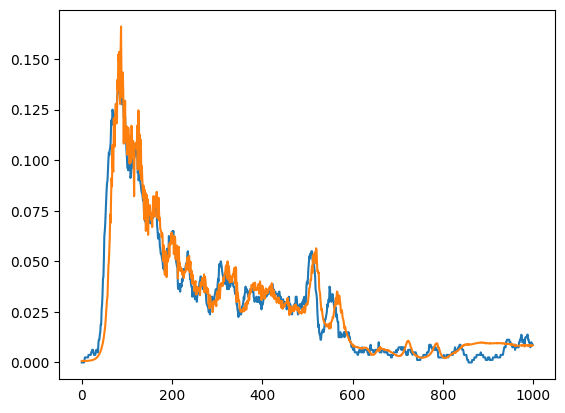

In [47]:
cumsum = np.cumsum(len_tr_train)
cumsum=np.concatenate(([0],cumsum))
start = cumsum[:-1]
end = cumsum[1:]

predicted_tr = []
for i_tr in range(s_on_train.shape[0]):
    st=int(s_on_train[i_tr])
    predicted_tr.append(rate_pred_train[start[i_tr]:end[i_tr]][st:int(st+1000)])
no_neu = np.where(neu_data.sample_id[mask][idxs_train][:s_on_train.shape[0]]!=0)[0]

sp_tr = []
for i_tr in range(s_on_train.shape[0]):
    st=int(s_on_train[i_tr])
    dat = sp_train[start[i_tr]:end[i_tr]]
    sp_tr.append(firing_rate.moving_average(data=dat, win=20, step = 1)[st:int(st+1000)])

plt.plot(np.array(sp_tr)[no_neu].mean(axis=0))
plt.plot(np.array(predicted_tr)[no_neu].mean(axis=0))

In [ ]:
rate_pred_test = np.exp(glm_const + dm_test@ wparams[1:])

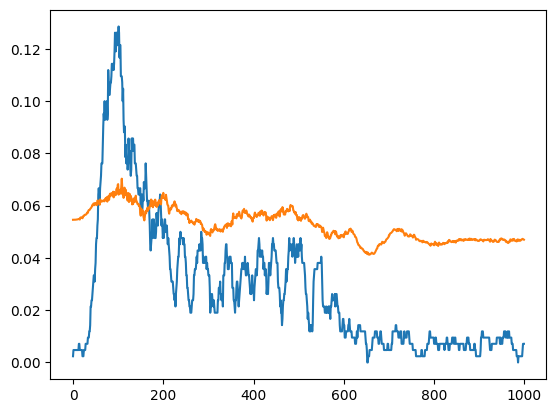

In [ ]:
cumsum = np.cumsum(len_tr_test)
cumsum=np.concatenate(([0],cumsum))
start = cumsum[:-1]
end = cumsum[1:]

predicted_tr = []
for i_tr in range(s_on_test.shape[0]):
    st=int(s_on_test[i_tr])
    predicted_tr.append(rate_pred_test[start[i_tr]:end[i_tr]][st:int(st+1000)])
no_neu = np.where(neu_data.sample_id[mask][:s_on_test.shape[0]]!=0)[0]

sp_tr = []
for i_tr in range(s_on_test.shape[0]):
    st=int(s_on_test[i_tr])
    dat = sp_test[start[i_tr]:end[i_tr]]
    sp_tr.append(firing_rate.moving_average(data=dat, win=20, step = 1)[st:int(st+1000)])

plt.plot(np.array(sp_tr)[no_neu].mean(axis=0))
plt.plot(np.array(predicted_tr)[no_neu].mean(axis=0)/10)

In [ ]:
sp_train[t_start:t_end][iiplot]/10

array([0., 0., 0., ..., 0., 0., 0.])

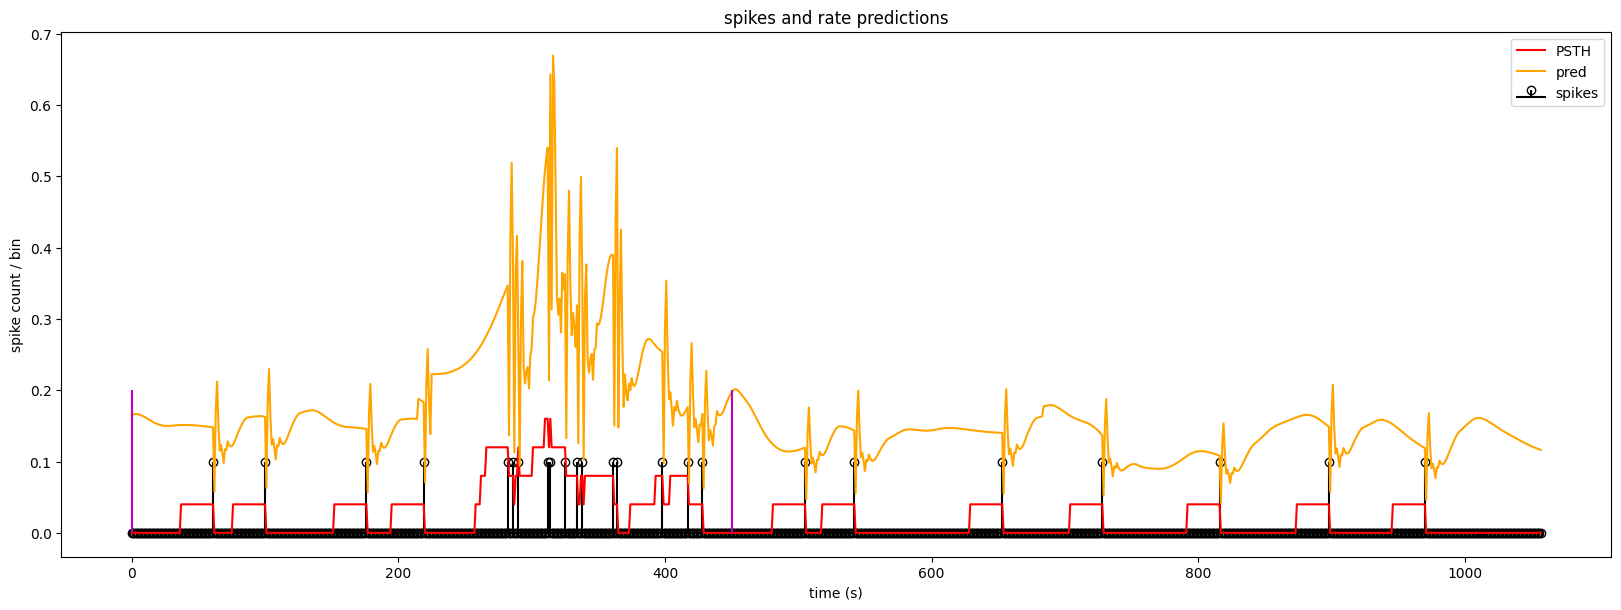

In [ ]:
# Compute predicted spike rate on training data
#rate_pred = np.exp(glm_const + dm_train@ glm_result.params[1:])
it=3
t_start,t_end=start[it],end[it]
# Make plot
fig = plt.figure(figsize=[20,15])
iiplot = np.arange(0,t_end-t_start)
ttplot = iiplot*1
plt.subplot(212)
markerline,_,_ = plt.stem(ttplot, (sp_train[t_start:t_end][iiplot]/10), linefmt='k-', basefmt='k-', label='spikes')
plt.setp(markerline, 'markerfacecolor', 'none')
plt.setp(markerline, 'markeredgecolor', 'k')
dat= sp_train[t_start:t_end]
plt.plot(ttplot,firing_rate.moving_average(data=dat, win=25, step = 1), c='red', label='PSTH')
plt.plot(ttplot,rate_pred_train[t_start:t_end], c='orange', label='pred')

_=plt.vlines(s_on_train[it],0,0.2,'m')
_=plt.vlines(s_on_train[it]+450,0,0.2,'m')
#_=plt.vlines(fix_on_train[it],0,0.2)

plt.legend()
plt.xlabel('time (s)')
plt.title('spikes and rate predictions')
plt.ylabel('spike count / bin')
plt.show()

In [ ]:
design_mat.shape

AttributeError: 'list' object has no attribute 'shape'

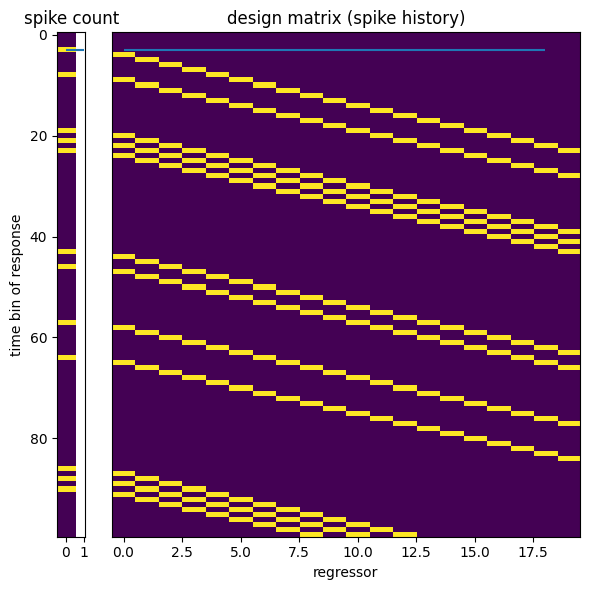

In [ ]:
ntfilt = 20     # Try varying this, to see how performance changes!

# Build the design matrix
padded_stim = np.hstack((np.zeros((ntfilt)), sp_train)) # pad early bins of stimulus with zero
design_mat_hist = np.zeros((len(sp_train),ntfilt))
for j in np.arange(len(sp_train)):
    design_mat_hist[j] = np.flip(padded_stim[j:j+ntfilt]) # grab last 'nkt' bins of stmiulus and insert into this row

t_train,_=dm_train.shape

#dm_train_offset = np.hstack((np.ones((t_train,1)), dm_train))  
fig = plt.figure(figsize=[6,6])
plt.subplot(1,10,(2,10))
plt.imshow(design_mat_hist[165:265], aspect='auto', interpolation='nearest')
plt.yticks(ticks=[], labels=[])
plt.hlines(3,0,18)
plt.xlabel('regressor')

plt.title('design matrix (spike history)')
plt.subplot(1,10,1)
plt.imshow(sp_train[165:265,np.newaxis], aspect='auto', interpolation='nearest')
plt.ylabel('time bin of response')
plt.title('spike count')
plt.tight_layout()
plt.hlines(3,0,1)
plt.show()

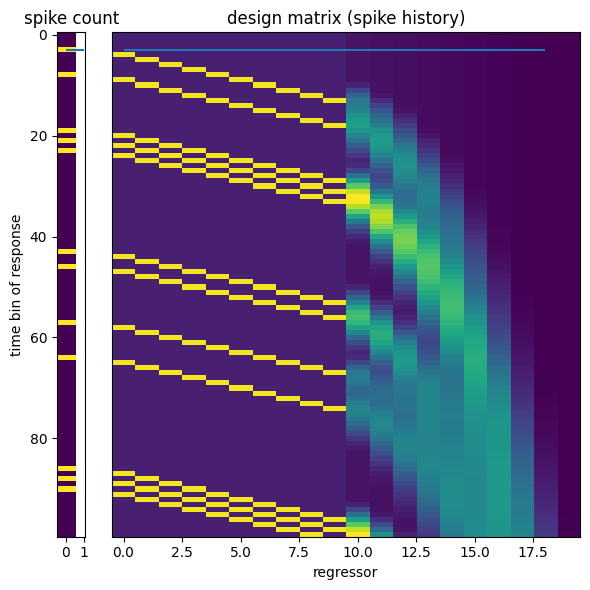

In [ ]:
fig = plt.figure(figsize=[6,6])
plt.subplot(1,10,(2,10))
plt.imshow(dm_train[165:265,0:20], aspect='auto', interpolation='nearest')
plt.yticks(ticks=[], labels=[])
plt.hlines(3,0,18)
plt.xlabel('regressor')

plt.title('design matrix (spike history)')
plt.subplot(1,10,1)
plt.imshow(sp_train[165:265,np.newaxis], aspect='auto', interpolation='nearest')
plt.ylabel('time bin of response')
plt.title('spike count')
plt.tight_layout()
plt.hlines(3,0,1)
plt.show()